DEPRECATED APIs.

# Discrete state space

In [1]:
import sys
import torchvision
import numpy as np
from envs.navigation.State import State
from envs.navigation.DiscreteStateSpace import DiscreteStateSpace
from envs.navigation.Dynamics import XYDynamics
from envs.navigation.StateFeature import FeatureStateIndicator, FeatureStateIndicatorOneHot, \
                                        FeatureClassIndicator, FeatureClassIndicatorOneHot, \
                                        FeatureClassImage, FeatureClassImageSampler
from envs.navigation.StateReward import RewardStateScalar
sys.path.append("./NavigationGridViews/")
from NavigationGridViews.navgridviews.Raster import Raster as NavGridView

from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

## Create n-dimensional state space

In [2]:
S = DiscreteStateSpace(2,2)
print(S)

[[[0 0]
  [0 1]]

 [[1 0]
  [1 1]]]


In [3]:
S = DiscreteStateSpace(2,2,3)
print(S)

[[[[0 0 0]
   [0 0 1]
   [0 0 2]]

  [[0 1 0]
   [0 1 1]
   [0 1 2]]]


 [[[1 0 0]
   [1 0 1]
   [1 0 2]]

  [[1 1 0]
   [1 1 1]
   [1 1 2]]]]


In [4]:
for s in S:
    print(s)

State: (0, 0, 0)
State: (0, 0, 1)
State: (0, 0, 2)
State: (0, 1, 0)
State: (0, 1, 1)
State: (0, 1, 2)
State: (1, 0, 0)
State: (1, 0, 1)
State: (1, 0, 2)
State: (1, 1, 0)
State: (1, 1, 1)
State: (1, 1, 2)


## Access a state by flattened index or location

In [5]:
print(S[0], S[1], S[2], S[-1])

State: (0, 0, 0) State: (0, 0, 1) State: (0, 0, 2) State: (1, 1, 2)


In [6]:
print(S.at_loc((0,0,0)), S.at_loc((0,0,1)), S.at_loc((1,1,1)))

State: (0, 0, 0) State: (0, 0, 1) State: (1, 1, 1)


## Attach concepts (classes)

In [7]:
S = DiscreteStateSpace(3,2)
S.sample_and_attach_classes([0,1,2,3,9], [1./5] * 5)
S.class_ids

array([3, 1, 2, 2, 0, 1])

In [8]:
# print("\n".join(["State {}, class {}".format(S[i].location, S[i].get_class()) for i in range(len(S))]))

In [9]:
S = DiscreteStateSpace(3,2)
S.attach_classes([9,0,1,0,3,2])
S.class_ids

array([9, 0, 1, 0, 3, 2])

In [10]:
# print("\n".join(["State {}, class {}".format(S[i].location, S[i].get_class()) for i in range(len(S))]))

## Features

### state indicator

In [11]:
PHI = FeatureStateIndicator(S)
print("Features flat: {}\nGridded: {}\nBy idx 0: {}\nBy loc (0,0): {}\nBy array index [0]: {}".format(
    PHI(gridded=False), PHI(gridded=True), PHI(idx=0), PHI(loc=(0,0)), PHI[0]))

Features flat: [0 1 2 3 4 5]
Gridded: [[0 1]
 [2 3]
 [4 5]]
By idx 0: 0
By loc (0,0): 0
By array index [0]: 0


### state indicator one hot 

In [12]:
PHI = FeatureStateIndicatorOneHot(S)
PHI()

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

### class indicator

In [13]:
PHI = FeatureClassIndicator(S)
PHI()

array([9, 0, 1, 0, 3, 2])

### class indicator one hot

In [14]:
PHI = FeatureClassIndicatorOneHot(S)
PHI()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

### class feature map (each class instance is a feature specified by map)

In [15]:
fmnist = torchvision.datasets.FashionMNIST(root="./", download=True)
X, y = fmnist.data, fmnist.targets
def sample_image(X, y, y_q):
    x_q = X[y == y_q].numpy()
    return x_q[np.random.randint(0, len(x_q))]

In [16]:
S = DiscreteStateSpace(4,6)
np.random.seed(0)
S.sample_and_attach_classes([0,1,2], [0.2, 0.3, 0.5])
PHI = FeatureClassImage(S, {cls: sample_image(X, y, cls) for cls in S.class_ids})
print(PHI().shape, PHI(gridded=True).shape)

(24, 28, 28) (4, 6, 28, 28)


Text(0.5, 1.0, 'State to sampled feature')

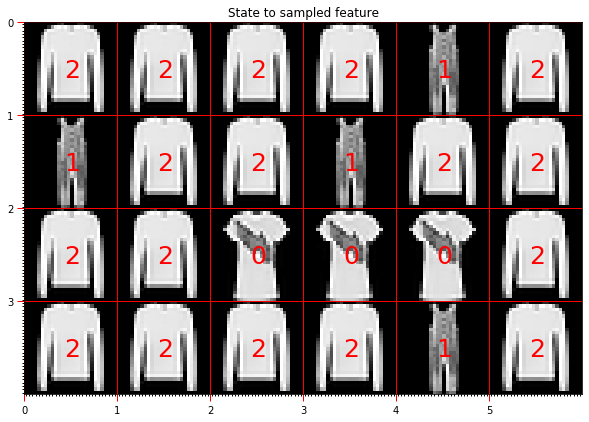

In [17]:
fig = plt.figure(figsize=(10,10))
NavGridView(PHI(gridded=True)[..., np.newaxis], ax=plt.gca()).render(cmap=cm.gray).ticks().grid().show_cell_text(
    S.class_ids, fmt=".1f", color_cb=lambda x: "red", fontsize=25)
plt.title("State to sampled feature")

### class feature sampler (each class instance is a sample of feature)

In [18]:
S = DiscreteStateSpace(4,6)
np.random.seed(0)
S.sample_and_attach_classes([0,1,2], [0.2, 0.3, 0.5])
PHI = FeatureClassImageSampler(S, feature_sampler=lambda y_q: sample_image(X, y, y_q))
print(PHI().shape, PHI(gridded=True).shape)

(24, 28, 28) (4, 6, 28, 28)


Text(0.5, 1.0, 'State to sampled feature')

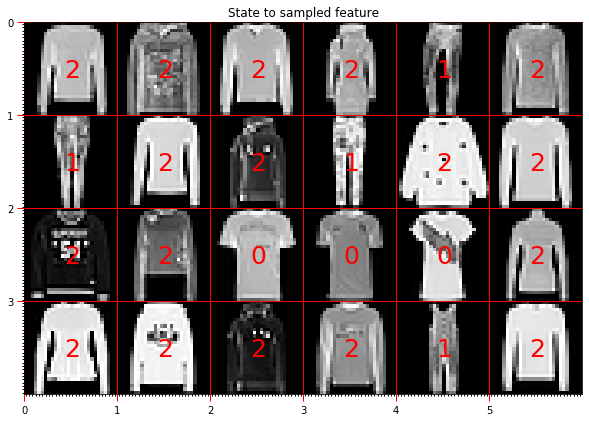

In [19]:
fig = plt.figure(figsize=(10,10))
NavGridView(PHI(gridded=True)[..., np.newaxis], ax=plt.gca()).render(cmap=cm.gray).ticks().grid().show_cell_text(
    S.class_ids, fmt=".1f", color_cb=lambda x: "red", fontsize=25)
plt.title("State to sampled feature")

## Attach features

In [20]:
S.attach_features(FeatureClassIndicatorOneHot(S))
print("Feature dim: {} \n"
      "S[0] features: {}".format(S.features().shape[1:], S[0].get_features()))

Feature dim: (3,) 
S[0] features: [0. 0. 1.]


# Rewards

In [21]:
R = RewardStateScalar(S, None, class_id_to_reward_dict={0: -1, 1: -2, 2: 1}, default=0)
R()

array([ 1,  1,  1,  1, -2,  1, -2,  1,  1, -2,  1,  1,  1,  1, -1, -1, -1,
        1,  1,  1,  1,  1, -2,  1])

Text(0.5, 1.0, 'Rewards')

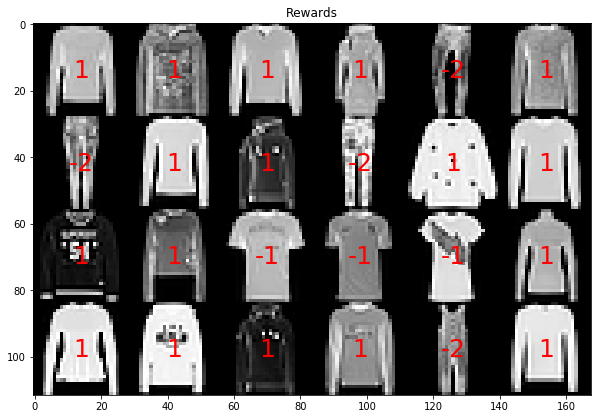

In [22]:
## Attach Rewards
S.attach_rewards(R)
fig = plt.figure(figsize=(10,10))
NavGridView(PHI(gridded=True)[..., np.newaxis], ax=plt.gca()).render(cmap=cm.gray).show_cell_text(
    S.rewards(), fontsize=25, color_cb=lambda x: "red")
plt.title("Rewards")

# Dynamics

In [23]:
def execute_static_plan(s_0, actions_list, dynamics_fn):
    traj = []
    s = s_0
    for a in actions_list:
        traj.append((s, a))
        s = dynamics_fn.take_action(s, a)
    traj.append((s, None))
    return traj

In [24]:
T = XYDynamics(S)
traj = execute_static_plan(S.loc_to_state_dict[(0,0)], ["U", "U", "R", "R", "U"], T)
traj_prime = [ (s.location[0], s.location[1], a) for s, a in traj]

Text(0.5, 1.0, 'State to sampled feature + trajectory')

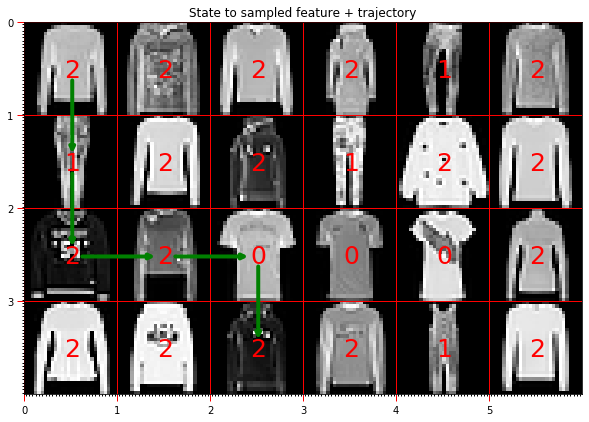

In [25]:
fig = plt.figure(figsize=(10,10))
p = NavGridView(PHI(gridded=True)[..., np.newaxis], ax=plt.gca()).render(cmap=cm.gray).ticks().grid().add_trajectory(
    traj_prime, True, {"lw": 4, "linestyle": "-", "shrinkB":10, "shrinkA":10}, color="green").show_cell_text(
    S.class_ids, fmt=".1f", color_cb=lambda x: "red", fontsize=25)
plt.title("State to sampled feature + trajectory")

### Cartesian coordinate plot

Note: Above plot trajectories seem to have Up-Down order flipped. It happens because the state space features are memory mapped (ordered row col wise). To fix it for visualization, we can simply invert the y axis, however it also causes images to be flipped vertically so we also need to flip the features along y dimension (which would be dim 2 when features are shaped in grid format).

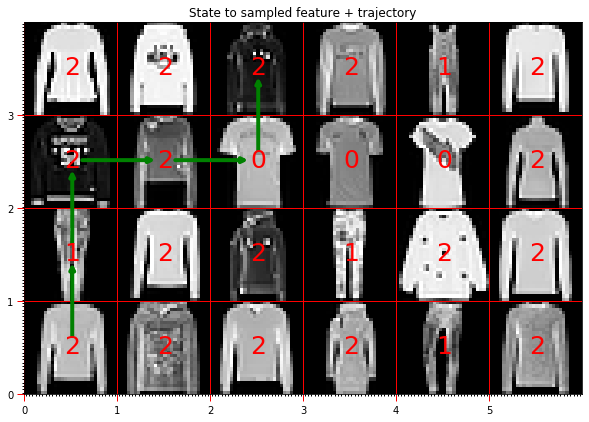

In [26]:
fig = plt.figure(figsize=(10,10))
p = NavGridView(np.flip(PHI(gridded=True)[..., np.newaxis], 2), ax=plt.gca()).render(cmap=cm.gray).ticks().grid().add_trajectory(
    traj_prime, True, {"lw": 4, "linestyle": "-", "shrinkB":10, "shrinkA":10}, color="green").show_cell_text(
    S.class_ids, fmt=".1f", color_cb=lambda x: "red", fontsize=25)
plt.title("State to sampled feature + trajectory")
p.ax.invert_yaxis()

## MNIST Example

In [27]:
fmnist = torchvision.datasets.MNIST(root="./", download=True)
X, y = fmnist.data, fmnist.targets
classes = np.unique(y)
n_classes = len(classes)

def sample_image(X, y, y_q):
    x_q = X[y == y_q].numpy()
    return x_q[np.random.randint(0, len(x_q))]

In [28]:
# Specify state space
S = DiscreteStateSpace(5,5)
# Attach classes
S.sample_and_attach_classes(classes, [1. / n_classes] * n_classes)
# Attach features
S.attach_features(FeatureClassImageSampler(S, lambda x: sample_image(X, y, x)))
PHI = S.features()
PHI_gridded = S.features(gridded=True)[..., np.newaxis]
PHI_gridded_inverted = np.flip(PHI_gridded, 2)
# Specify dynamics
T = XYDynamics(S)

In [29]:
traj = execute_static_plan(S.loc_to_state_dict[(0,0)], ["U", "U", "R", "R", "U"], T)
traj_prime = [(s.location[0], s.location[1], a) for s, a in traj]

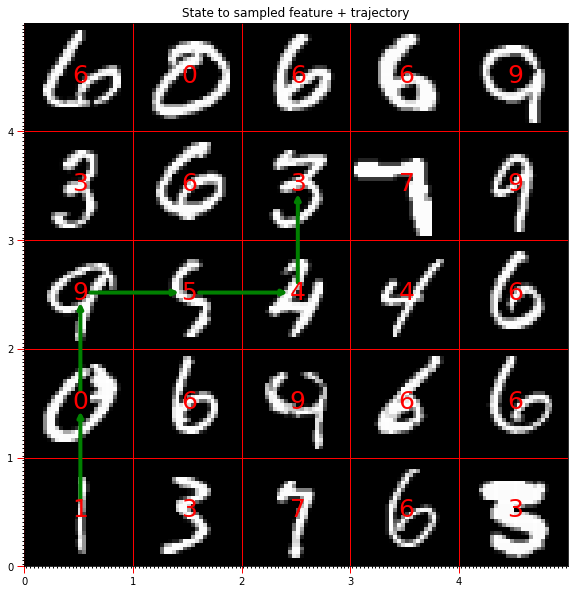

In [30]:
fig = plt.figure(figsize=(10,10))
p = NavGridView(PHI_gridded_inverted, ax=plt.gca()).render(
    cmap=cm.gray).ticks().grid().add_trajectory(
    traj_prime, True, {"lw": 4, "linestyle": "-", "shrinkB":10, "shrinkA":10}, color="green").show_cell_text(
    S.class_ids, fmt=".1f", color_cb=lambda x: "red", fontsize=25)
plt.title("State to sampled feature + trajectory")
p.ax.invert_yaxis()